<a href="https://colab.research.google.com/github/ShabibSaleh/DPAM-Nutrition/blob/main/Task1_Calculate_population_weighted_coverage_of_health_services.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Read Data From Google Sheet

In [65]:
!pip install --upgrade gspread google-auth

In [66]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

In [67]:
# Open a sheet from a spreadsheet by name
spreadsheet = gc.open('DPAM Population-weighted coverage of health services')

# If you have the URL, you can do it this way:
# spreadsheet = gc.open_by_url('Your_Spreadsheet_URL')

# Data preparation and Cleaning

## on-track and off-track countries dataset

In [68]:
# Get a worksheet by name
worksheet = spreadsheet.worksheet('On & off-track countries')

# Get all values from the worksheet
rows = worksheet.get_all_values()




In [69]:
#Convert data to pandas DataFrame (if needed)
import pandas as pd
on_off_track_df = pd.DataFrame.from_records(rows[1:],columns=rows[0])  # Skip header row

In [70]:
# Checking for any missing values and the data types in the dataframe
on_off_track_df.info()

# Summary statistics to understand numerical columns, although most data seems categorical
on_off_track_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ISO3Code      200 non-null    object
 1   OfficialName  200 non-null    object
 2   Status.U5MR   200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB


,ISO3Code,OfficialName,Status.U5MR
count,200,200,200
unique,200,200,3
top,AFG,Afghanistan,Achieved
freq,1,1,134


In [71]:
# Step 1: Check for duplicates
duplicates = on_off_track_df.duplicated().sum()

# Step 2: Checking the unique values in the "Status.U5MR" column to ensure consistency
unique_status_values = on_off_track_df['Status.U5MR'].unique()

# Step 3: Renaming columns for clarity
on_off_track_df_cleaned = on_off_track_df.rename(columns={
    'ISO3Code': 'Country Code',
    'OfficialName': 'Country Name',
    'Status.U5MR': 'U5MR Status'
})

# Displaying the results
duplicates, unique_status_values, on_off_track_df_cleaned.head()


(0,
 array(['Acceleration Needed', 'Achieved', 'On Track'], dtype=object),
   Country Code Country Name          U5MR Status
 0          AFG  Afghanistan  Acceleration Needed
 1          AGO       Angola  Acceleration Needed
 2          AIA     Anguilla             Achieved
 3          ALB      Albania             Achieved
 4          AND      Andorra             Achieved)

In [72]:
# Updating the values in the 'U5MR Status' column
on_off_track_df_cleaned['U5MR Status'] = on_off_track_df_cleaned['U5MR Status'].replace({
    'Achieved': 'On-Track',
    'On Track': 'On-Track',
    'Acceleration Needed': 'Off-Track'
})

# Displaying the first few rows to confirm the changes
on_off_track_df_cleaned.head()


,Country Code,Country Name,U5MR Status
0,AFG,Afghanistan,Off-Track
1,AGO,Angola,Off-Track
2,AIA,Anguilla,On-Track
3,ALB,Albania,On-Track
4,AND,Andorra,On-Track


Extract on-track and off-track cleaned data countries dataset to new Google sheet

In [73]:
# Add a new sheet with a name and specify rows and columns
worksheet_title = 'on_off_track_df_cleaned'

ws = spreadsheet.worksheet(worksheet_title)

In [74]:
# Use the gspread_dataframe to set the DataFrame to the sheet
from gspread_dataframe import set_with_dataframe
# Set the DataFrame to the worksheet
set_with_dataframe(ws, on_off_track_df_cleaned)

## ANC4 & SAB Data

In [75]:
# Get a worksheet by name
ANC4_SAB_worksheet = spreadsheet.worksheet('ANC4 & SAB Data')

# Get all values from the worksheet
ANC4_SAB_rows = ANC4_SAB_worksheet.get_all_values()

In [76]:
# Checking the general information and structure of the ANC4 & SAB Data sheet
anc4_sab_df = pd.DataFrame.from_records(ANC4_SAB_rows[1:],columns=ANC4_SAB_rows[0])  # Skip header row
anc4_sab_df.info()

# Summary statistics for numerical columns
anc4_sab_df.describe(include='all')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 291 entries, 0 to 290
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Geographic area  291 non-null    object
 1   Indicator        291 non-null    object
 2   Sex              291 non-null    object
 3   2022             291 non-null    object
 4   2021             291 non-null    object
 5   2020             291 non-null    object
 6   2019             291 non-null    object
 7   2018             291 non-null    object
dtypes: object(8)
memory usage: 18.3+ KB


,Geographic area,Indicator,Sex,2022,2021,2020,2019,2018
count,291,291,291,291,291,291,291,291
unique,181,2,1,62,34,54,71,84
top,Latin America and the Caribbean,Skilled birth attendant - percentage of delive...,Female,-,-,-,-,-
freq,7,159,291,210,251,213,175,159


In [77]:
# Converting the column names to strings
anc4_sab_df.columns = anc4_sab_df.columns.astype(str)


year_columns = ['2022', '2021', '2020', '2019', '2018']
anc4_sab_df[year_columns] = anc4_sab_df[year_columns].apply(pd.to_numeric, errors='coerce')

# Step 3: Drop the "Sex" column as it is redundant
anc4_sab_df_cleaned = anc4_sab_df.drop(columns=['Sex'])

# Displaying the cleaned data to verify
anc4_sab_df_cleaned.head()


,Geographic area,Indicator,2022,2021,2020,2019,2018
0,Afghanistan,Antenatal care 4+ visits - percentage of women...,NaN,NaN,27.6,NaN,20.9
1,Afghanistan,Skilled birth attendant - percentage of delive...,NaN,NaN,61.8,NaN,58.8
2,Africa,Antenatal care 4+ visits - percentage of women...,56.8,NaN,NaN,NaN,NaN
3,Africa,Skilled birth attendant - percentage of delive...,71.0,NaN,NaN,NaN,NaN
4,Albania,Antenatal care 4+ visits - percentage of women...,NaN,NaN,NaN,NaN,77.8


In [78]:
# Creating a new column 'Most Recent Coverage Estimate' which takes the most recent non-null value from 2018 to 2022
anc4_sab_df_cleaned['Most Recent Coverage Estimate'] = anc4_sab_df_cleaned[year_columns].bfill(axis=1).iloc[:, 0]

# Displaying the updated dataframe
anc4_sab_df_cleaned.head()


,Geographic area,Indicator,2022,2021,2020,2019,2018,Most Recent Coverage Estimate
0,Afghanistan,Antenatal care 4+ visits - percentage of women...,NaN,NaN,27.6,NaN,20.9,27.6
1,Afghanistan,Skilled birth attendant - percentage of delive...,NaN,NaN,61.8,NaN,58.8,61.8
2,Africa,Antenatal care 4+ visits - percentage of women...,56.8,NaN,NaN,NaN,NaN,56.8
3,Africa,Skilled birth attendant - percentage of delive...,71.0,NaN,NaN,NaN,NaN,71.0
4,Albania,Antenatal care 4+ visits - percentage of women...,NaN,NaN,NaN,NaN,77.8,77.8


In [79]:
# Dropping the year columns as requested
anc4_sab_df_cleaned = anc4_sab_df_cleaned.drop(columns=year_columns)

# Displaying the cleaned dataframe with the year columns removed
anc4_sab_df_cleaned.head()


,Geographic area,Indicator,Most Recent Coverage Estimate
0,Afghanistan,Antenatal care 4+ visits - percentage of women...,27.6
1,Afghanistan,Skilled birth attendant - percentage of delive...,61.8
2,Africa,Antenatal care 4+ visits - percentage of women...,56.8
3,Africa,Skilled birth attendant - percentage of delive...,71.0
4,Albania,Antenatal care 4+ visits - percentage of women...,77.8


In [80]:
# Replacing the values in the 'Indicator' column as requested
anc4_sab_df_cleaned['Indicator'] = anc4_sab_df_cleaned['Indicator'].replace({
    'Antenatal care 4+ visits - percentage of women (aged 15-49 years) attended at least four times during pregnancy by any provider': 'ANC4',
    'Skilled birth attendant - percentage of deliveries attended by skilled health personnel': 'SAB'
})

# Displaying the updated dataframe to confirm changes
anc4_sab_df_cleaned.head()


,Geographic area,Indicator,Most Recent Coverage Estimate
0,Afghanistan,ANC4,27.6
1,Afghanistan,SAB,61.8
2,Africa,ANC4,56.8
3,Africa,SAB,71.0
4,Albania,ANC4,77.8


In [81]:
# Creating a pivot table with 'Geographic area' as the index, 'Indicator' as columns, and summing 'Most Recent Coverage Estimate'
anc4_sab_pivot = anc4_sab_df_cleaned.pivot_table(
    index='Geographic area',
    columns='Indicator',
    values='Most Recent Coverage Estimate',
    aggfunc='sum'
).reset_index()

# Displaying the resulting pivot table
anc4_sab_pivot.head()


Indicator,Geographic area,ANC4,SAB
0,Afghanistan,27.6,61.8
1,Africa,56.8,71.0
2,Albania,77.8,99.8
3,Algeria,69.8,98.8
4,Americas,94.0,96.8


In [82]:
# Renaming the 'Geographic area' column to 'Country Name'
anc4_sab_pivot.rename(columns={'Geographic area': 'Country Name'}, inplace=True)

# Displaying the updated pivot table
anc4_sab_pivot.head()


Indicator,Country Name,ANC4,SAB
0,Afghanistan,27.6,61.8
1,Africa,56.8,71.0
2,Albania,77.8,99.8
3,Algeria,69.8,98.8
4,Americas,94.0,96.8


Extract ANC4 & SAB cleaned dataset to new Google sheet

In [83]:
# Add a new sheet with a name and specify rows and columns
worksheet_title = 'anc4_sab_df_cleaned'

ws = spreadsheet.worksheet(worksheet_title)

In [84]:
# Use the gspread_dataframe to set the DataFrame to the sheet
from gspread_dataframe import set_with_dataframe
# Set the DataFrame to the worksheet
set_with_dataframe(ws, anc4_sab_pivot)

## Population data

In [85]:
# Get a worksheet by name
population_worksheet = spreadsheet.worksheet('Population data')

# Get all values from the worksheet
population_rows = population_worksheet.get_all_values()

# Checking the general information and structure of the ANC4 & SAB Data sheet
population_df = pd.DataFrame.from_records(population_rows[1:],columns=population_rows[0])  # Skip header row
population_df.info()

# Filtering the Projections Population  data where Year = 2022 and Type = 'Country/Area'
population_df_filtered = population_df[
    (population_df['Year'] == '2022') &
    (population_df['Type'] == 'Country/Area')
]

# Selecting the relevant columns as per the user's request
selected_columns = [
    'Index',
    'Variant',
    'Region, subregion, country or area *',
    'Notes',
    'Location code',
    'ISO3 Alpha-code',
    'ISO2 Alpha-code',
    'SDMX code**',
    'Type',
    'Parent code',
    'Year',
    'Total Population, as of 1 January (thousands)',
    'Total Population, as of 1 July (thousands)',
    'Male Population, as of 1 July (thousands)',
    'Female Population, as of 1 July (thousands)',
    'Births (thousands)',
    'Births by women aged 15 to 19 (thousands)',
    'Crude Birth Rate (births per 1,000 population)',
    'Total Fertility Rate (live births per woman)',
    'Net Reproduction Rate (surviving daughters per woman)',
    'Mean Age Childbearing (years)',
    'Sex Ratio at Birth (males per 100 female births)',
    'Live Births Surviving to Age 1 (thousands)',
    'Under-Five Deaths, under age 5 (thousands)',
    'Under-Five Mortality (deaths under age 5 per 1,000 live births)'
]

# Selecting only these columns and dropping others
population_df_selected = population_df_filtered[selected_columns]



# Renaming the columns
population_df_selected.rename(columns={
    'Region, subregion, country or area *': 'Country Name',
    'ISO3 Alpha-code': 'Country Code'
}, inplace=True)

# Displaying the first few rows to confirm the changes
population_df_selected.head()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237 entries, 0 to 236
Data columns (total 25 columns):
 #   Column                                                           Non-Null Count  Dtype 
---  ------                                                           --------------  ----- 
 0   Index                                                            237 non-null    object
 1   Variant                                                          237 non-null    object
 2   Region, subregion, country or area *                             237 non-null    object
 3   Notes                                                            237 non-null    object
 4   Location code                                                    237 non-null    object
 5   ISO3 Alpha-code                                                  237 non-null    object
 6   ISO2 Alpha-code                                                  237 non-null    object
 7   SDMX code**                                          

,Index,Variant,Country Name,Notes,Location code,Country Code,ISO2 Alpha-code,SDMX code**,Type,Parent code,...,Births (thousands),Births by women aged 15 to 19 (thousands),"Crude Birth Rate (births per 1,000 population)",Total Fertility Rate (live births per woman),Net Reproduction Rate (surviving daughters per woman),Mean Age Childbearing (years),Sex Ratio at Birth (males per 100 female births),Live Births Surviving to Age 1 (thousands),"Under-Five Deaths, under age 5 (thousands)","Under-Five Mortality (deaths under age 5 per 1,000 live births)"
0,1901,Medium,Burundi,,108,BDI,BI,108,Country/Area,910,...,440.0,37.0,34.1,5,2.2,31,103.00,426.0,22,51
1,1980,Medium,Comoros,,174,COM,KM,174,Country/Area,910,...,24.0,2.0,28.9,4,1.8,31,103.00,23.3,1,58
2,2059,Medium,Djibouti,,262,DJI,DJ,262,Country/Area,910,...,25.0,1.0,21.9,3,1.2,31,104.00,23.8,1,51
3,2138,Medium,Eritrea,,232,ERI,ER,232,Country/Area,910,...,105.0,14.0,28.4,4,1.7,29,103.00,102.4,4,38
4,2217,Medium,Ethiopia,,231,ETH,ET,231,Country/Area,910,...,3 928,450.0,31.8,4,1.8,30,106.00,3820.0,169,44


In [86]:
# Merging all three datasets on 'Country Name'
merged_df = pd.merge(on_off_track_df_cleaned,anc4_sab_pivot, on='Country Name', how='left')
merged_df = pd.merge(merged_df, population_df_selected, on='Country Name', how='left')

# Displaying the first few rows of the merged dataset
merged_df.head()

,Country Code_x,Country Name,U5MR Status,ANC4,SAB,Index,Variant,Notes,Location code,Country Code_y,...,Births (thousands),Births by women aged 15 to 19 (thousands),"Crude Birth Rate (births per 1,000 population)",Total Fertility Rate (live births per woman),Net Reproduction Rate (surviving daughters per woman),Mean Age Childbearing (years),Sex Ratio at Birth (males per 100 female births),Live Births Surviving to Age 1 (thousands),"Under-Five Deaths, under age 5 (thousands)","Under-Five Mortality (deaths under age 5 per 1,000 live births)"
0,AFG,Afghanistan,Off-Track,27.6,61.8,8142,Medium,,4,AFG,...,1 447,187.0,35.1,5,2.0,29,105.00,1397.1,76,53
1,AGO,Angola,Off-Track,NaN,NaN,3560,Medium,,24,AGO,...,1 360,254.0,38.2,5,2.3,29,103.00,1306.7,93,69
2,AIA,Anguilla,On-Track,NaN,100.0,15805,Medium,19,660,AIA,...,0,0,9.4,1,0.6,28,104.00,0.1,0,7
3,ALB,Albania,On-Track,77.8,99.8,13514,Medium,,8,ALB,...,29.0,1.0,10.1,1,0.7,29,107.00,28.6,0,9
4,AND,Andorra,On-Track,NaN,NaN,13593,Medium,,20,AND,...,1.0,0,7.2,1,0.6,32,106.00,0.6,0,6


## Extract Whole Clean and prepare data to Google Sheet

In [87]:
# Add a new sheet with a name and specify rows and columns
worksheet_title = 'Merged_Cleaned_Data'

ws = spreadsheet.worksheet(worksheet_title)
# Use the gspread_dataframe to set the DataFrame to the sheet
from gspread_dataframe import set_with_dataframe
# Set the DataFrame to the worksheet
set_with_dataframe(ws, merged_df)

# Calculate weighted averages for on-track and off-track countries

Filter the data where ANC4 or SAB have a value (not NaN)  for countries with a coverage estimate between 2018 to 2022

In [88]:
df = merged_df
# Filter the data where ANC4 or SAB have a value (not NaN)  for countries with a coverage estimate between 2018 to 2022.
filtered_df = df[(df['ANC4'].notna()) | (df['SAB'].notna())]




**Identify the Variables:**


*   𝑥
𝑖: This will be the ANC4 and SAB coverage for each country.


*   𝑤
𝑖 : This will be the number of projected Births (thousands)*1000 (which we can approximate using the births data available).

**Apply the Formula:**



*   Calculate the numerator: ∑
𝑖
=
1
𝑛
𝑥
𝑖
𝑤
𝑖
∑
i=1
n
​
 x
i
​
 w
i
​
 , which is the sum of the product of coverage and births across all countries in each category (on-track and off-track).



*   Calculate the denominator:∑
𝑖
=
1
𝑛
𝑤
𝑖
∑
i=1
n
​
 w
i
​
 , which is the total number of projected births for all countries in each category.



*   Divide the numerator by the denominator to get the weighted coverage.

In [89]:



import pandas as pd
import matplotlib.pyplot as plt
df = filtered_df


# Filtering the data for On-Track and Off-Track countries
on_track_df = df[df['U5MR Status'] == 'On-Track'].copy()
off_track_df = df[df['U5MR Status'] == 'Off-Track'].copy()

# Cleaning birth data by removing commas and spaces, and converting to float
on_track_df.loc[:, 'Births (thousands)'] = on_track_df['Births (thousands)'].str.replace(',', '').str.replace(' ', '').astype(float)
off_track_df.loc[:, 'Births (thousands)'] = off_track_df['Births (thousands)'].str.replace(',', '').str.replace(' ', '').astype(float)

# Adjusting the birth numbers by multiplying by 1000
on_track_df.loc[:, 'Births (thousands)'] = on_track_df['Births (thousands)'] * 1000
off_track_df.loc[:, 'Births (thousands)'] = off_track_df['Births (thousands)'] * 1000



# Calculating the numerator for on-track and off-track countries
numerator_anc4_on_track = (on_track_df['ANC4'] * on_track_df['Births (thousands)']).sum()
numerator_sab_on_track = (on_track_df['SAB'] * on_track_df['Births (thousands)']).sum()

numerator_anc4_off_track = (off_track_df['ANC4'] * off_track_df['Births (thousands)']).sum()
numerator_sab_off_track = (off_track_df['SAB'] * off_track_df['Births (thousands)']).sum()

# Calculating the denominator (total births) for on-track and off-track countries
denominator_on_track = on_track_df['Births (thousands)'].sum()
denominator_off_track = off_track_df['Births (thousands)'].sum()

# Calculating the weighted coverage for ANC4 and SAB
weighted_coverage_anc4_on_track = numerator_anc4_on_track / denominator_on_track
weighted_coverage_sab_on_track = numerator_sab_on_track / denominator_on_track

weighted_coverage_anc4_off_track = numerator_anc4_off_track / denominator_off_track
weighted_coverage_sab_off_track = numerator_sab_off_track / denominator_off_track


(weighted_coverage_anc4_on_track, weighted_coverage_sab_on_track, weighted_coverage_anc4_off_track, weighted_coverage_sab_off_track)

(57.224890978166066, 77.15541561340488, 52.97644857743828, 52.859515111258716)

# Visualization

Create a visualization of your choice comparing population-weighted coverage estimates for on-track and off-track countries for each indicator, with a short paragraph on interpretation and caveats.

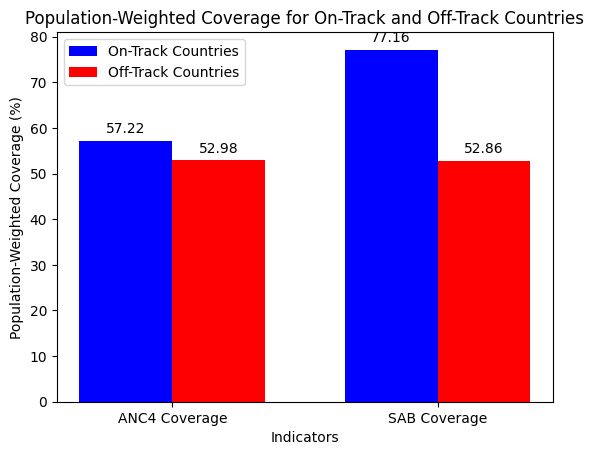

In [90]:
# Data to plot
categories = ['ANC4 Coverage', 'SAB Coverage']
on_track_values = [weighted_coverage_anc4_on_track, weighted_coverage_sab_on_track]
off_track_values = [weighted_coverage_anc4_off_track, weighted_coverage_sab_off_track]

# Create a bar chart
fig, ax = plt.subplots()
bar_width = 0.35
index = range(len(categories))

bar1 = ax.bar(index, on_track_values, bar_width, label='On-Track Countries', color='blue')
bar2 = ax.bar([i + bar_width for i in index], off_track_values, bar_width, label='Off-Track Countries', color='red')

# Adding labels and title
ax.set_xlabel('Indicators')
ax.set_ylabel('Population-Weighted Coverage (%)')
ax.set_title('Population-Weighted Coverage for On-Track and Off-Track Countries')
ax.set_xticks([i + bar_width/2 for i in index])
ax.set_xticklabels(categories)
ax.legend()

# Adding data labels on top of bars
for bar in bar1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

for bar in bar2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom', fontsize=10)

# Display the plot
plt.show()

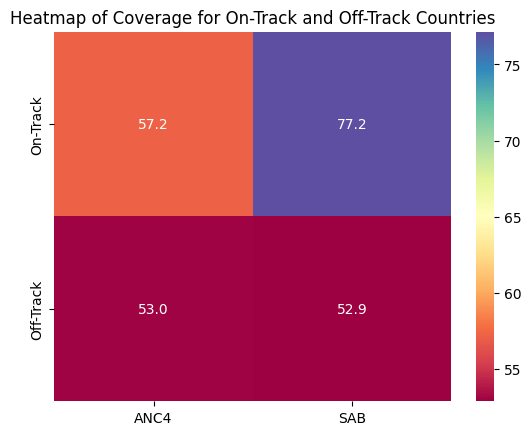

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create synthetic data for demonstration, replace with actual data if available
heatmap_data = np.array([[weighted_coverage_anc4_on_track, weighted_coverage_sab_on_track],
                         [weighted_coverage_anc4_off_track, weighted_coverage_sab_off_track]])

# Create a heatmap
fig, ax = plt.subplots()
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap='Spectral', xticklabels=['ANC4', 'SAB'], yticklabels=['On-Track', 'Off-Track'])

# Adding title
ax.set_title('Heatmap of Coverage for On-Track and Off-Track Countries')

# Display the plot
plt.show()


In [116]:
# Calculating the weighted coverage for ANC4 and SAB per country
df=filtered_df
# Cleaning birth data by removing commas and spaces, and converting to float for the entire dataset
df['Births (thousands)'] = df['Births (thousands)'].astype(str).str.replace(',', '').str.replace(' ', '').astype(float)

# Adjusting the birth numbers by multiplying by 1000
df['Births (thousands)'] = df['Births (thousands)'] * 1000

# Calculating the weighted coverage for ANC4 and SAB per country
df['Weighted ANC4'] = df['ANC4'] * df['Births (thousands)'] / df['Births (thousands)'].sum()
df['Weighted SAB'] = df['SAB'] * df['Births (thousands)'] / df['Births (thousands)'].sum()

# Selecting relevant columns for display
weighted_coverage_df = df[['Country Name', 'Weighted ANC4', 'Weighted SAB']]

weighted_coverage_df.head()


,Country Name,Weighted ANC4,Weighted SAB
0,Afghanistan,0.354016,0.792687
2,Anguilla,NaN,0.000000
3,Albania,0.020000,0.025655
5,United Arab Emirates,NaN,0.081779
6,Argentina,0.503237,0.549998


<ipython-input-120-00d738b1a9a6>:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


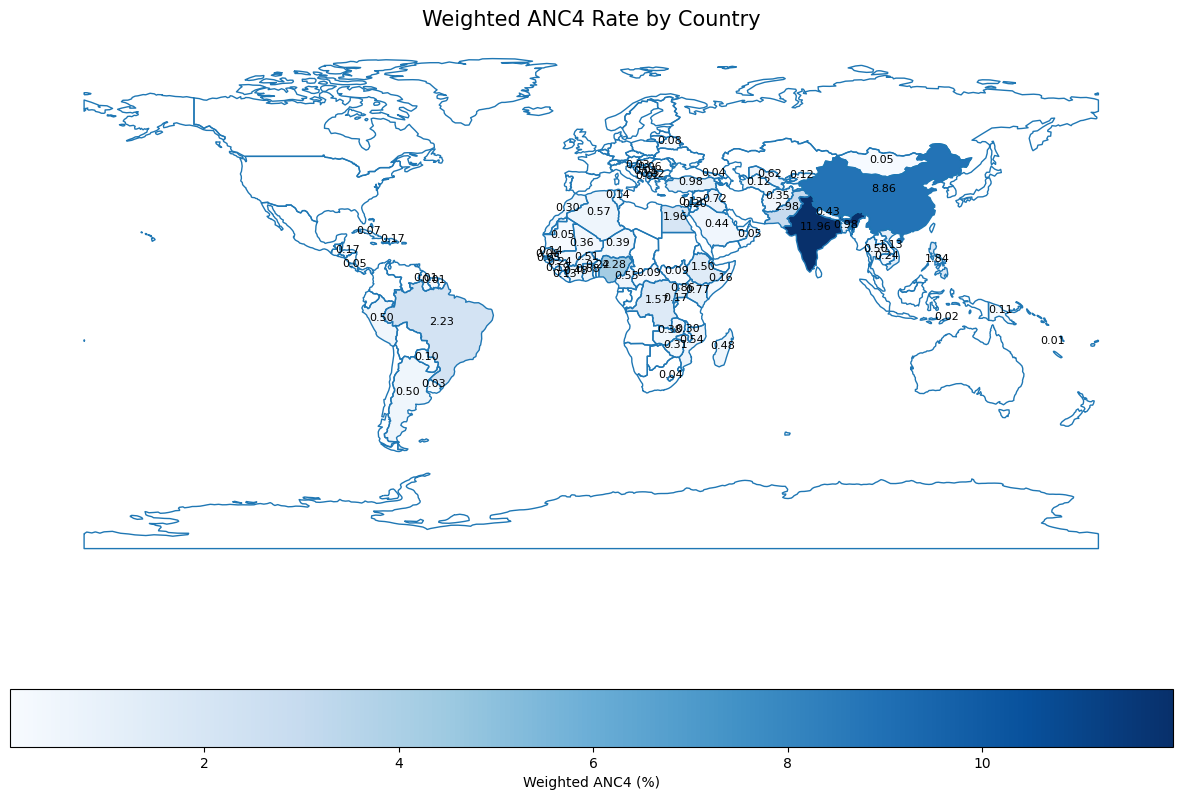

In [120]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the provided Excel file

df

# Load a world map with simplified geometry to avoid complex issues
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the provided data on country codes (ISO Alpha-3 code)
merged_df = world.merge(df, left_on='iso_a3', right_on='Country Code_y', how='left')

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_df.boundary.plot(ax=ax, linewidth=1)
merged_df.plot(column='Weighted ANC4', ax=ax, legend=True, cmap='Blues',
               legend_kwds={'label': "Weighted ANC4 (%)", 'orientation': "horizontal"})

# Annotate each country with its Weighted ANC4 value
for idx, row in merged_df.iterrows():
    if not pd.isna(row['Weighted ANC4']):
        plt.text(x=row['geometry'].centroid.x,
                 y=row['geometry'].centroid.y,
                 s=f'{row["Weighted ANC4"]:.2f}',
                 fontsize=8,
                 ha='center',
                 color='black')


ax.set_title('Weighted ANC4 Rate by Country', fontsize=15)
ax.set_axis_off()

plt.show()


<ipython-input-121-ef85904ceff1>:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


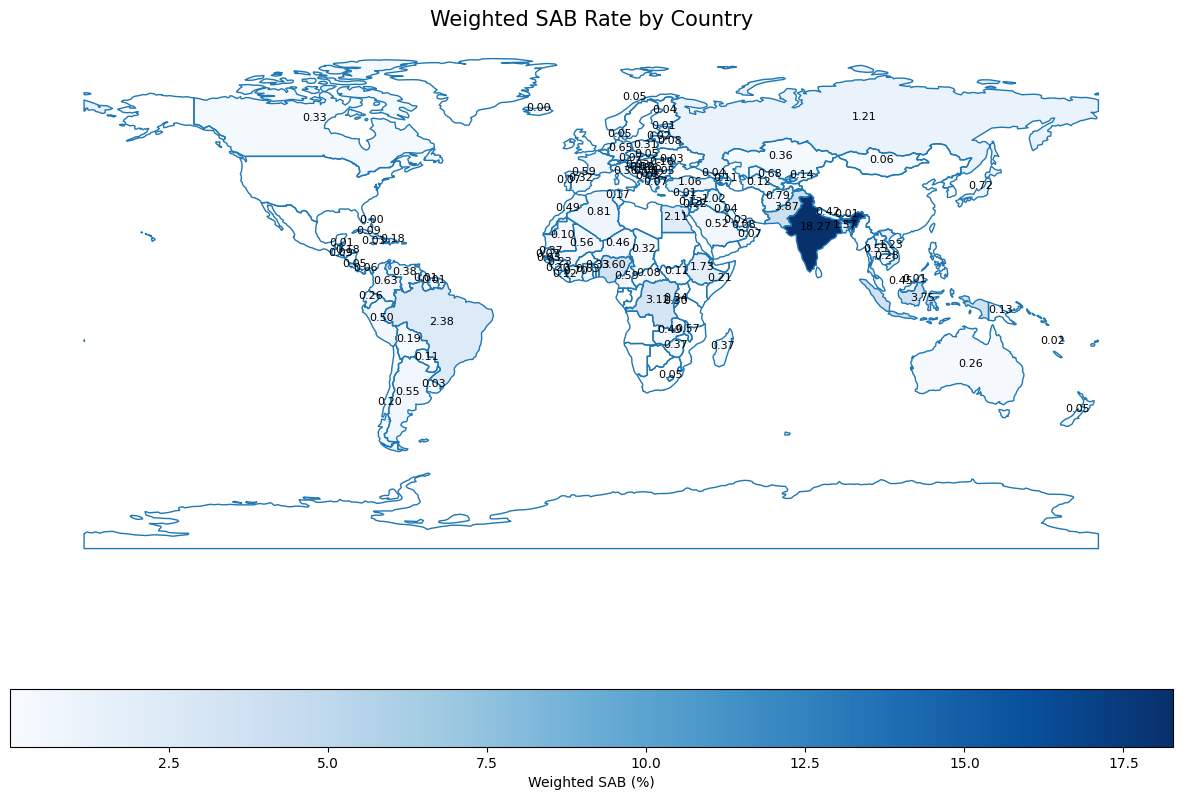

In [121]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the provided Excel file

df

# Load a world map with simplified geometry to avoid complex issues
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the provided data on country codes (ISO Alpha-3 code)
merged_df = world.merge(df, left_on='iso_a3', right_on='Country Code_y', how='left')

# Plotting the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
merged_df.boundary.plot(ax=ax, linewidth=1)
merged_df.plot(column='Weighted SAB', ax=ax, legend=True, cmap='Blues',
               legend_kwds={'label': "Weighted SAB (%)", 'orientation': "horizontal"})

# Annotate each country with its Weighted ANC4 value
for idx, row in merged_df.iterrows():
    if not pd.isna(row['Weighted SAB']):
        plt.text(x=row['geometry'].centroid.x,
                 y=row['geometry'].centroid.y,
                 s=f'{row["Weighted SAB"]:.2f}',
                 fontsize=8,
                 ha='center',
                 color='black')


ax.set_title('Weighted SAB Rate by Country', fontsize=15)
ax.set_axis_off()

plt.show()


## interpretation

The bar chart visually compares the population-weighted coverage of key maternal health services (ANC4 and SAB) between countries categorized as on-track and off-track for achieving under-5 mortality reduction targets.

**Key Observations:**

**On-Track Countries:**

*    Generally, higher coverage in both ANC4 (about 57.22%) and SAB (about 77.
16%).

**Off-Track Countries:**

*    Significantly lower coverage in ANC4 (about 52.97%) and SAB (about 52.85%).


This comparison highlights the disparity in healthcare services provided to mothers in countries that are either on track or off track in reducing under-5 mortality. It underscores the need for increased focus and resources in off-track countries to improve maternal health services, which are critical for reducing under-5 mortality rates.

**Caveats**

**Data Quality:**

*   The accuracy of the results is heavily dependent on the quality and
completeness of the data. Missing or inconsistent data can lead to skewed results, potentially obscuring the true state of healthcare coverage. Additionally, variations in how data is collected and reported across different countries can introduce inconsistencies that may affect the comparability of the results.
**Source**: WHO. (2020). Global Health Estimates 2020: Data Quality and Comparability. Retrieved from WHO website.

**Population Weighting:**

*   The use of birth numbers as a proxy for population size assumes that the need for health services like ANC4 and SAB scales linearly with the number of births. This method does not account for other critical factors such as age distribution, the presence of high-risk pregnancies, or varying healthcare needs within populations. It also assumes that all births have equal access to healthcare services, which might not be true in areas with significant disparities in healthcare infrastructure.
**Source**: Lawn, J. E., et al. (2014). Every Newborn: progress, priorities, and potential beyond survival. The Lancet. Retrieved from The Lancet.

**Global Comparisons**:

*   Comparing countries with vastly different healthcare systems, economic conditions, and cultural contexts on the same scale may oversimplify the complexities involved. For instance, a country with a robust healthcare system but low coverage due to population spread might be unfairly compared to a densely populated country with fewer healthcare challenges. These comparisons might not accurately reflect the unique challenges each country faces in improving healthcare services.
**Source**: Marmot, M. (2005). Social determinants of health inequalities. The Lancet. Retrieved from The Lancet.

**Temporal Differences**:

The data may reflect conditions at different times across various countries, particularly if data collection periods differ. Healthcare coverage can change rapidly due to policy shifts, economic conditions, or public health interventions. Therefore, the results might not fully capture the current state of healthcare coverage in all countries.
**Source**: Murray, C. J. L., et al. (2020). Global Burden of Disease 2019: A systematic analysis for the Global Burden of Disease Study 2019. The Lancet. Retrieved from The Lancet.

**Service Quality vs. Access**:

*   The analysis focuses on coverage rates, which measure access to healthcare services, but it does not assess the quality of those services. High coverage does not necessarily equate to high-quality care, and in some cases, access to services might be universal, but the quality of care received could be suboptimal, impacting health outcomes.
**Source**: Kruk, M. E., et al. (2018). High-quality health systems in the Sustainable Development Goals era: time for a revolution. The Lancet Global Health. Retrieved from The Lancet Global Health.


**Political and Social Factors**:

The analysis does not consider the impact of political stability, conflict, or social factors such as gender inequality, which can significantly influence healthcare access and outcomes. In conflict zones, for example, healthcare infrastructure may be severely compromised, leading to lower coverage rates that are not solely a function of healthcare system performance.
**Source**: De Jong, J. T. V. M., et al. (2013). Mental health in post-conflict settings. The Lancet. Retrieved from The Lancet.

**Regional Disparities Within Countries:**

*   The analysis treats each country as a uniform entity, but significant disparities often exist within countries, particularly between urban and rural areas. National averages might mask these regional differences, leading to an incomplete understanding of the true distribution of healthcare services within a country.
**Source**: WHO. (2018). Global Health Observatory Data: Urban vs Rural Health Coverage. Retrieved from WHO website.